# Large Language Models Workshop
## Hands-on Introduction to LLMs

This notebook provides interactive demonstrations of key LLM concepts. We'll cover:
1. Neural Networks & Gradient Descent
2. Tokenization
3. Transformer Architecture
4. Loading Models & Chat Templates
5. Uncertainty Quantification
6. RAG
7. Quantization
8. Super Weights


This notebook also includes interactive demos to help better learn concepts, since I don't want to overwhelm you with code, the demo codes are imported and the code itself can be found on the following repo: https://github.com/haziq-exe/LLM_Workshop

---

## Setup: Install Required Libraries

In [ ]:
!rm -rf /content/LLM_Workshop

In [ ]:
!git clone https://github.com/haziq-exe/LLM_Workshop

Cloning into 'LLM_Workshop'...
remote: Enumerating objects: 51, done.
remote: Counting objects: 100% (51/51), done.
remote: Compressing objects: 100% (34/34), done.
remote: Total 51 (delta 13), reused 47 (delta 9), pack-reused 0 (from 0)
Receiving objects: 100% (51/51), 11.77 KiB | 11.77 MiB/s, done.
Resolving deltas: 100% (13/13), done.


In [ ]:
!pip install -q transformers torch accelerate sentencepiece protobuf numpy matplotlib scipy bitsandbytes

In [ ]:
!pip install ipywidgets

ERROR: Operation cancelled by user
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/pip/_internal/cli/base_command.py", line 179, in exc_logging_wrapper
    status = run_func(*args)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pip/_internal/cli/req_command.py", line 67, in wrapper
    return func(self, options, args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pip/_internal/commands/install.py", line 447, in run
    conflicts = self._determine_conflicts(to_install)
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pip/_internal/commands/install.py", line 578, in _determine_conflicts
    return check_install_conflicts(to_install)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pip/_internal/operations/check.py", line 101, in check_install_conflicts
    package_set, _ = create_package_

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from LLM_Workshop.PartII_Tokenization.TokenizationDemo import TokenizationDemo
from LLM_Workshop.PartI_NeuralNets.GradientDescentDemo import GradientDescentDemo
from LLM_Workshop.PartIII_Attention.AttentionDemo import AttentionDemo
from LLM_Workshop.PartV_Uncertainty.UncertaintyDemo import TokenUncertaintyVisualizer
from LLM_Workshop.PartVIII_SuperWeight.SuperWeight import SuperWeightDemo

---
# PART I: Neural Networks - How They Learn



Neural networks learn by minimizing a **loss function** through **gradient descent**.

### Key Concepts:
- **Loss Function**: Measures how wrong our predictions are
- **Gradient Descent**: Algorithm that adjusts weights to reduce loss
- **Partial Derivatives**: Tells us which direction to move each weight to decrease loss

The update rule: `weight_new = weight_old - learning_rate × ∂Loss/∂weight`

### Ball Finding Minimum via Gradient Descent

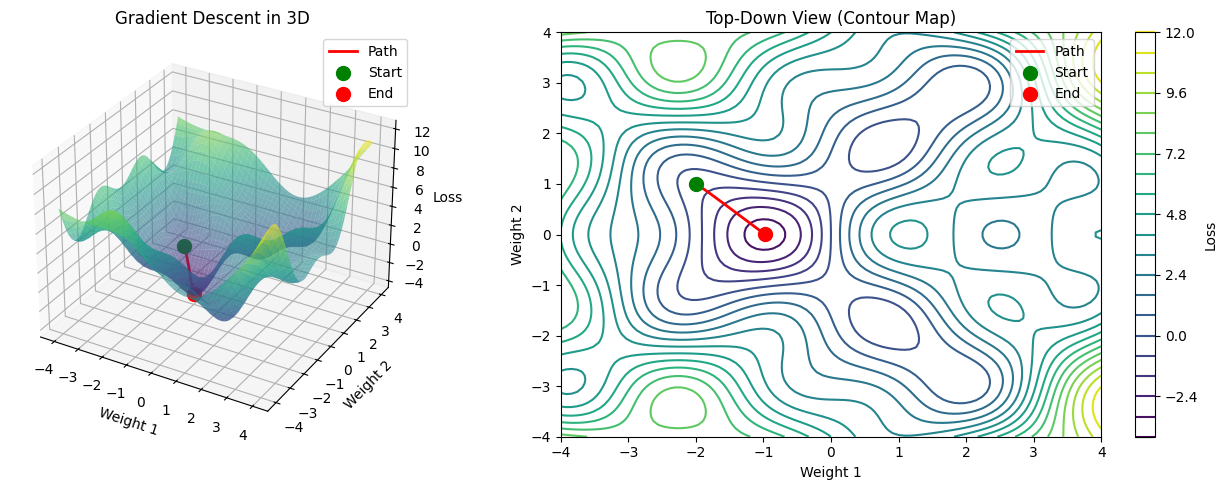

Starting loss: -0.4463
Final loss: -3.5913


In [ ]:
_ = GradientDescentDemo(
    START_X = -2.0,
    START_Y = 1.0,
    LEARNING_RATE = 0.01,
    NUM_STEPS = 100
)

Try playing around with inital points and learning rates to get a feel for how they affect the gradient descent process.

---
- **Learning Rate** affects convergence speed and stability
  - Too small: slow convergence
  - Too large: may overshoot or diverge
- **Local Minima**: The ball can get stuck depending on starting position (try starting at X=2 and Y=4 to see this)
- In real neural networks, we update millions/billions of weights simultaneously using the same principle

---

For more indepth info on gradient descent I recommend this 3Blue1Brown video: https://www.youtube.com/watch?v=IHZwWFHWa-w

# PART II: Tokenization & Embeddings


Language models don't process text directly. They:
1. **Tokenize**: Split text into tokens (subword units)
2. **Convert to IDs**: Each token → integer ID
3. **Embed**: Look up learned vector representation for each token ID

A lot of the weird quirks and odd tasks that LLMs seem to struggle with can be attributed to tokenization. For example, LLMs struggle to count letters in text or reverse string, try inputting a string in the demo below and you will see why

## Tokenization & Counting Problem

In [ ]:
t_demo = TokenizationDemo(tokenizer_name="gpt2")

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Enter a string to tokenize:
strawberry

--- Input Summary ---
Raw text: 'strawberry'
Character count: 10
Token count: 3

Tokens and IDs:
          st  →  301
         raw  →  1831
       berry  →  8396


https://tiktokenizer.vercel.app/ <- Website has a live demo of what this code does, feel free to test out different tokenizers and how they differ

### Notes:
- Words are often split into multiple tokens
- Common words/patterns → single tokens
- Rare words/patterns → multiple tokens
- **This is why LLMs struggle with character-level tasks** (counting letters, reversing words, etc.)

---

For more indepth information on tokenizers I recommend this Andrej Karpathy tutorial: https://www.youtube.com/watch?v=zduSFxRajkE&t=955s

## Embeddings

### Token IDs vs Embeddings

Token IDs are **not** the inputs to a language model in a mathematical sense.
They are simply **indices** used to look up rows in an embedding table.

An **embedding table** can look something like this:

| Token ID | Token  | Embedding Vector (dim = 4 for illustration) |
|--------:|--------|----------------------------------------------|
| 0 | `<pad>` | [ 0.02, -0.11,  0.34,  0.09 ] |
| 1 | `the`   | [ 0.18,  0.05, -0.27,  0.41 ] |
| 2 | `man`   | [ 0.63, -0.12,  0.08,  0.55 ] |
| 3 | `woman` | [ 0.61, -0.10,  0.06,  0.53 ] |
| 4 | `king`  | [ 0.72, -0.05,  0.19,  0.68 ] |
| 5 | `queen` | [ 0.70, -0.04,  0.17,  0.66 ] |

---

When a token appears in text, the model:

1. Uses the token ID as an index
2. Retrieves the corresponding embedding vector
3. Uses that vector as the actual input to the hidden layers

---

### How Embeddings Are Learned

Embeddings are **learned parameters**, just like weights in a neural network.

During training:

* The model makes a prediction
* A loss is computed
* Gradients are backpropagated
* The embedding vectors of the tokens involved are slightly adjusted

Over many training steps:

* Tokens that appear in similar contexts are pushed toward similar vectors
* Tokens that behave differently are pushed apart

This happens **implicitly**, without any explicit notion of meaning or rules.

---

### Why Embeddings Capture Concepts

Because embeddings are optimized to support prediction:

* Words used interchangeably end up close in vector space
* Relationships become encoded as directions in that space



In [ ]:
%%html
<iframe width="560" height="315" src="https://www.youtubetrimmer.com/view/?v=wjZofJX0v4M&start=905&end=927&loop=0" frameborder="0" allowfullscreen></iframe>

Complete video: https://www.youtube.com/watch?v=wjZofJX0v4M

We can also use this concept to steer LLMs in a certain way (couldn't include in this workshop):
https://www.youtube.com/watch?v=F2jd5WuT-zg

# PART III: Transformer Architecture - Attention Mechanism

The core of transformers is the **attention mechanism**:
- Each token can "attend to" (look at) every other token in the sequence
- Tokens exchange information to build contextual understanding
- **Context Length**: Maximum number of tokens the model can process at once

Every token can look at all other tokens in the sequence, including itself.



---

### Q, K & V Vectors

Each token starts as an embedding vector.
That embedding is linearly projected into **three different vectors**:

* **Query (Q)**
  What this token is looking for.

* **Key (K)**
  What this token offers.

* **Value (V)**
  The information this token contains.

These are **learned** linear transformations applied to the same embedding.

---

### How Attention Is Computed

For a given token:

1. **Compare its Query to every Key**

   * This measures relevance between tokens.

2. **Normalize with softmax**

   * Converts scores into weights that sum to 1.
   * Higher weight = more attention paid.

3. **Weighted sum of Values**

   * Multiply each Value vector by its attention weight.
   * Sum them to produce a new representation.

This produces a **context-aware embedding** for the token.

---


Here is a demo, you can see the attention values for each token with each other. You can also switch attention heads (One set of K Q V vectors make up an attention head, in transformers you split one embedding into multiple K Q V vectors simulatenously thus giving you many attention heads)

In [ ]:
AttentionDemo()

Loading tokenizer and model (bert-base-uncased) on cpu — this may take a moment...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Enter a short sentence to inspect attention (keep it short):
The cat wore a hat

Tokens (idx : token):
 0: [CLS]
 1: the
 2: cat
 3: wore
 4: a
 5: hat
 6: [SEP]


Output()

# PART IV: Loading Models & Chat Templates

### Loading a Model with HuggingFace

We'll use **SmolLM2-135M**, a capable small language model (<1B parameters).

In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch

In [ ]:
model_name = "HuggingFaceTB/SmolLM2-135M-Instruct"

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    dtype=torch.float16, # We will speak more about this parameter in a later section
    device_map="auto" # This parameter automatically loads the model onto your gpu/cpu (i.e: If you have a large model that needs two gpus, this would automatically split the model across those gpus)
)

model.eval()

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/655 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/861 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors:   0%|          | 0.00/269M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/132 [00:00<?, ?B/s]

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(49152, 576, padding_idx=2)
    (layers): ModuleList(
      (0-29): 30 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear(in_features=576, out_features=576, bias=False)
          (k_proj): Linear(in_features=576, out_features=192, bias=False)
          (v_proj): Linear(in_features=576, out_features=192, bias=False)
          (o_proj): Linear(in_features=576, out_features=576, bias=False)
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=576, out_features=1536, bias=False)
          (up_proj): Linear(in_features=576, out_features=1536, bias=False)
          (down_proj): Linear(in_features=1536, out_features=576, bias=False)
          (act_fn): SiLUActivation()
        )
        (input_layernorm): LlamaRMSNorm((576,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((576,), eps=1e-05)
      )
    )
    (norm): LlamaRMSNorm((576,), eps=1e-05)
    (r

You should be able to now understand some of the layers in the model above (like how their K and V vectors have 192 dimensions)

### Prompting the Model

In [ ]:
prompt = """If John has 3 apples and he buys 4 more apples, how many apples does he now have? """

In [ ]:
inputs = tokenizer(prompt, return_tensors="pt").to(model.device) # Get's the token_ids of the prompt using the tokenizer

with torch.no_grad(): # This line makes sure we don't calculate gradients during the generation process (since we don't need to do gradient descent), this saves significant time and memory
    outputs = model.generate(
        **inputs,
        max_new_tokens=50
    )

# model.generate returns many things like attention values, hidden state values etc. The output of the model will be in the [0] index position

print(tokenizer.decode(outputs[0], skip_special_tokens=True)) # We use the tokenizer to decode the token_id outputs of the model back into text


If John has 3 apples and he buys 4 more apples, how many apples does he now have? 
John buys 4 apples and he buys 3 more apples.


Output was not as expected, the model didn't answer the question properly. That's because we didn't use any special tokens that the model was finetuned with

### Special Tokens and Finetuning

After pre-training, modern models undergo **instruction tuning / RLHF**.

During this phase:

* Conversations are formatted with **special tokens**
* These tokens mark:

  * system instructions
  * user messages
  * assistant responses

Examples (model-dependent):

```
<|system|>
<|user|>
<|assistant|>
```

The model learns when to answer, when to stop and how to structure responses

Hugging Face provides a **chat template** that formats prompts exactly as the model expects.

In [ ]:
messages = [
    {"role" : "system", "content": "You are a helpful math tutor."},
    {"role": "user", "content": prompt}
]

In [ ]:
formatted_prompt = tokenizer.apply_chat_template(
    messages,
    tokenize=False,
    add_generation_prompt=True
)

print(formatted_prompt)

<|im_start|>system
You are a helpful math tutor.<|im_end|>
<|im_start|>user
If John has 3 apples and he buys 4 more apples, how many apples does he now have? <|im_end|>
<|im_start|>assistant



In [ ]:
inputs = tokenizer(formatted_prompt, return_tensors="pt").to(model.device)

with torch.no_grad():
    outputs = model.generate(
        **inputs,
        max_new_tokens=50
    )

print(tokenizer.decode(outputs[0], skip_special_tokens=False))

<|im_start|>system
You are a helpful math tutor.<|im_end|>
<|im_start|>user
If John has 3 apples and he buys 4 more apples, how many apples does he now have? <|im_end|>
<|im_start|>assistant
John has 3 apples.
He buys 4 more apples, so he now has 3 + 4 = 7 apples.
#### 7
The answer is: 7<|im_end|>


The model now recognizes where the user message ends and where the assistant response should begin. Output quality typically improves significantly

In [ ]:
# Code to only extract new tokens
generated_new_ids = outputs[:, inputs["input_ids"].shape[1]:]
print(tokenizer.batch_decode(generated_new_ids, skip_special_tokens=True)[0])

John has 3 apples.
He buys 4 more apples, so he now has 3 + 4 = 7 apples.
#### 7
The answer is: 7


### Sampling

When an LLM predicts the next token, it outputs a probability distribution that consists of every token in its vocabulary.

**Greedy Decoding**: Always pick the token with the highest predicted probability.

**Sampling**: Sample from the distribution based on probabilities. Allows for diversity and is a way to induce creativity in responses.

Temperature controls how peaked or flat the output probability distribution is. Low temperature means a peaked distribution (few tokens dominate the distribution), High temperature means a more flat distribution (probability is more spread out).



In [ ]:
sampling_prompt = [{"role" : "user", "content" : "Write me a very short mystical poem about a mythical creature"}]
formatted = tokenizer.apply_chat_template(sampling_prompt, tokenize=False, add_generation_prompt=True)
inputs = tokenizer(formatted, return_tensors="pt")

In [ ]:
with torch.no_grad():
    outputs = model.generate(
        **inputs,
        max_new_tokens=50,
        do_sample=True,
        temperature=1.0,
    )

poem = outputs[:, inputs["input_ids"].shape[1]:]
print(tokenizer.batch_decode(poem, skip_special_tokens=True)[0])

---
# PART V: Uncertainty Quantification




Language models sometimes generate incorrect information (**hallucinations**).

Measuring uncertainty accurately would allow us to predict when these hallucinations occur thus making models more reliable.

### Measuring Uncertainty using the output probability distribution

1. **Token-level Entropy**: How spread out is the probability distribution for each token?
   - High entropy (very spread out) = model is uncertain about next token
   - Low entropy (not spread out) = model is confident
   
2. **Perplexity**: Exponential of average token entropy
   - Lower = more confident

In [ ]:
def token_entropy(logits):
    probs = torch.softmax(logits, dim=-1)
    entropy = -torch.sum(probs * torch.log(probs + 1e-12))
    return entropy

The formula to calculate entropy is called Shannon Entropy, it is not exclusive to LLM's output probability distributions, it is a common formula that is used to find the entropy in any discrete probability distribution

In [ ]:
prompt = "What is the name of the thousandth person born on Mars?" # In an ideal world, the model should refuse to answer.

messages = [{"role": "user", "content": prompt}]
formatted_prompt = tokenizer.apply_chat_template(
    messages,
    tokenize=False,
    add_generation_prompt=True
)

inputs = tokenizer(formatted_prompt, return_tensors="pt").to(model.device)

with torch.no_grad():
    outputs = model.generate(
        **inputs,
        max_new_tokens=80,
        do_sample=True,
        temperature=1.0,
        output_scores=True,
        return_dict_in_generate=True
    )

In [ ]:
text = outputs[0][:, inputs["input_ids"].shape[1]:]
generated_text = tokenizer.batch_decode(text, skip_special_tokens=True)[0]

print(generated_text)

"Nova Terra" is the name of the thousandth person born on Mars.


In [ ]:
# Stack into [num_generated_tokens, vocab_size]
logits = torch.stack(outputs.scores, dim=0)

In [ ]:
token_index = 2

H = token_entropy(logits[token_index])
print(f"Entropy at token {token_index}: {H.item():.4f}")

Entropy at token 2: 2.9859


Entropy is calculated per calculated token and then averaged

In [ ]:
entropies = [token_entropy(logits[i]) for i in range(logits.size(0))]
avg_entropy = torch.mean(torch.stack(entropies))

print(f"Average token-level entropy: {avg_entropy.item():.4f}")

Average token-level entropy: 0.6990


Perplexity is simply e raised to the power of shannon entropy

In [ ]:
perplexity = torch.exp(avg_entropy)
print(f"Perplexity: {perplexity.item():.4f}")

Perplexity: 2.0118


Use the demo below to see a visual of the probability distribution of LLMs, you can change the prompt to see how the distribution changes when you ask it an easier question

In [ ]:
prompt = "What is the name of the thousandth person born on Mars?"

messages = [{"role": "user", "content": prompt}]
formatted_prompt = tokenizer.apply_chat_template(
    messages,
    tokenize=False,
    add_generation_prompt=True
)

In [ ]:
viz = TokenUncertaintyVisualizer(
    model=model,
    tokenizer=tokenizer,
    prompt=formatted_prompt
)

In [ ]:
viz.generate_and_store_output(max_new_tokens=10, temperature=1.0, do_sample=True)


--- Generated Output ---
system
You are a helpful AI assistant named SmolLM, trained by Hugging Face
user
What is the name of the thousandth person born on Mars?
assistant
The question about Mars and the 1,0

--- Generated Tokens (index : token) ---
 0 : 'The' : entropy = 0.8418729305267334
 1 : 'Ġquestion' : entropy = 1.6965312957763672
 2 : 'Ġabout' : entropy = 2.9858973026275635
 3 : 'ĠMars' : entropy = 0.37849175930023193
 4 : 'Ġand' : entropy = 0.24465635418891907
 5 : 'Ġthe' : entropy = 1.0590581893920898
 6 : 'Ġ' : entropy = 0.8550803661346436
 7 : '1' : entropy = 1.4010918140411377
 8 : ',' : entropy = 1.025098204612732
 9 : '0' : entropy = 0.04417818784713745


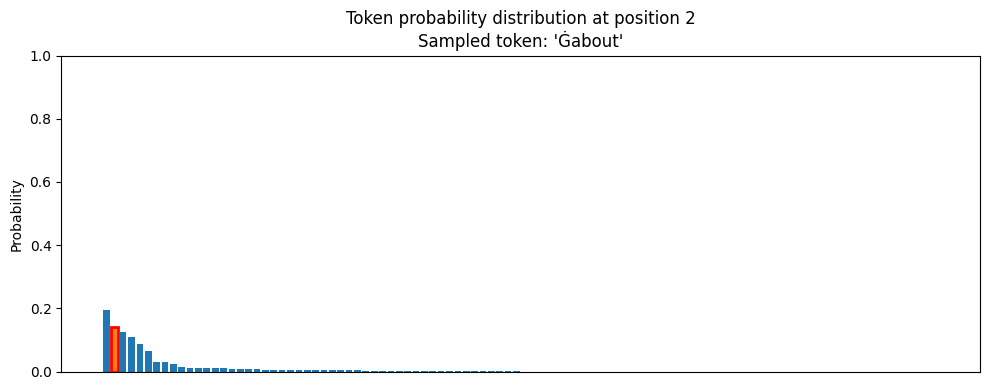

In [ ]:
viz.plot_token_distribution_at_position(token_index=2)

These methods are **not perfect**. This is an active research area with no single best solution. Token entropy and semantic entropy are commonly used baselines for comparison.

- High entropy doesn't always mean hallucination
- Low entropy doesn't guarantee correctness
- Models can be confidentally wrong
- Token-level metrics miss semantic-level patterns

**Other Methods:**
- Semantic entropy (generate multiple times and measure how much responses differ semantically)
- Self-consistency checking (generate multiple times, check agreement)
- Verbalized Confidence (Ask model to output its confidence along with the response)
- Factuality detection models

---

# PART VI: Retrieval-Augmented Generation (RAG)

## Why RAG is needed

### Stale knowledge

LLMs are trained on outdated fixed information.

Example:

```
Which artist won Album of the year Grammy in 2026?
```

The model either:

* Hallucinates
* Admits uncertainty
* Gives outdated information

---

### Long context is expensive & slow

Attention complexity is **O(n²)** in sequence length.

In [ ]:
model_name = "HuggingFaceTB/SmolLM2-135M-Instruct"

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    dtype=torch.float16, # We will speak more about this parameter in a later section
    device_map="auto" # This parameter automatically loads the model onto your gpu/cpu (i.e: If you have a large model that needs two gpus, this would automatically split the model across those gpus)
)

model.eval()

In [ ]:
short_context = "Translate the following word to French: apple"
long_context = "word " * 8000  # artificially long context

import time

def time_generation(prompt):
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
    start = time.time()
    with torch.no_grad():
        model.generate(**inputs, max_new_tokens=1)
    return time.time() - start

print("Short context time:", time_generation(short_context))
print("Long context time:", time_generation(long_context))


Short context time: 2.1170108318328857
Long context time: 4.647336006164551


As you can see above, the more tokens in your context history the more time and compute you need for your output

---

## Vanilla RAG (from scratch)

### Core idea

1. Store external knowledge
2. Retrieve only relevant pieces
3. Inject them into the prompt

In [ ]:
documents = [
    "The Grammy Awards are presented annually by the Recording Academy.",
    "They were held in 2026.",
    "Artist Bad Bunny won Album of the Year in 2026.",
]

In practice, documents are really large with a lot of text that is split into chunks

Chunking is usually:

* 200–500 tokens
* Overlapping windows (end of chunk 1 overlaps with beginning of chunk 2)

Nowadays, models are fine-tuned to recognize when they are asked a question that requires newer information they were not trained on, then the model does a google search retrieving the first k relevant pages, then the model can perform RAG on those pages in order to extract the relevant information

In [ ]:
from sentence_transformers import SentenceTransformer
import torch

embedder = SentenceTransformer("all-MiniLM-L6-v2")

doc_embeddings = embedder.encode(documents, convert_to_tensor=True)

query = "Which artist won Album of the year in 2026 at the Grammys?"
query_embedding = embedder.encode(query, convert_to_tensor=True)

scores = torch.matmul(doc_embeddings, query_embedding)
top_k = torch.topk(scores, k=2).indices
retrieved_docs = [documents[i] for i in top_k]

Embedding models follow the same concept we spoke about earlier with regards to embeddings in LLMs, these models will embed the prompt and then embed each chunk, after doing so you can retrieve the k closest chunks to your prompt

In [ ]:
context = "\n".join(retrieved_docs)

prompt = f"""
Use the following context to answer the question.

Context:
{context}

Question:
{query}
"""

print(prompt)


Use the following context to answer the question.

Context:
The Grammy Awards are presented annually by the Recording Academy.
Artist Bad Bunny won Album of the Year in 2026.

Question:
Which artist won Album of the year in 2026 at the Grammys?



After embedding we can rewrite our prompt in a cleaner, easier to understand way for the model

This solves the issue of outdated information, however suppose our issue is not outdated information, but rather, the issue we have is our context window has gotten excessively large and we need to get rid of some of it. Here we can use **AttentionRAG**

---

## AttentionRAG

> Use the model’s own **attention weights** to decide which tokens in the context are still relevant.

AttentionRAG:

1. Runs the model once
2. Extracts attention scores
3. Prunes low-attention context
4. Regenerates with a shorter, cleaner context

In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch

model_name = "HuggingFaceTB/SmolLM2-135M-Instruct"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    dtype=torch.float16,
    device_map="auto",
    output_attentions=True
)

### Step 2 — Build RAG prompt (same as vanilla)

In [ ]:
context_chunks = retrieved_docs  # from earlier retrieval
question = "Which artist won Album of the year Grammy in 2026?"

context_text = "\n".join(context_chunks)

prompt = f"""
Context:
{context_text}

Question:
{question}

Answer:
"""
print(prompt)


Context:
The Grammy Awards are presented annually by the Recording Academy.
Artist Bad Bunny won Album of the Year in 2026.

Question:
Which artist won Album of the year Grammy in 2026?

Answer:



#### Step 3 - Forward Pass to get attention weights

In [ ]:
inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

with torch.no_grad():
    outputs = model(
        **inputs,
        output_attentions=True,
        use_cache=False
    )

attentions = outputs.attentions  # list of layers

#### Extract attention weights from last layer and average

In [ ]:
last_layer_attn = attentions[-1][0]
attn_mean = last_layer_attn.mean(dim=0)  # Average over heads

input_ids = inputs["input_ids"][0]
tokens = tokenizer.convert_ids_to_tokens(input_ids)


question_start = tokens.index("Question")
answer_start = tokens.index("Answer")

question_indices = range(question_start, answer_start)
context_indices = range(0, question_start)

We separate Question and Context tokens using the strings `"Question"` and `"Answer"` in our context so we can compare chunks in the question section with chunks in the context section

#### Rank chunks

In [ ]:
chunk_scores = []
current_pos = 0

for chunk in context_chunks:
    chunk_len = len(tokenizer(chunk)["input_ids"])
    chunk_range = range(current_pos, current_pos + chunk_len)

    score = attn_mean[question_indices, :][:, chunk_range].mean().item()
    chunk_scores.append(score)

    current_pos += chunk_len

#### Rewrite prompt with irrelevant context pruned

In [ ]:
top_chunks = [
    chunk for _, chunk in sorted(
        zip(chunk_scores, context_chunks),
        reverse=False
    )[:1] # We retrieve the most relevant chunk
]

pruned_context = "\n".join(top_chunks)

final_prompt = f"""
Context:
{pruned_context}

Question:
{question}

Answer:
"""

print(final_prompt)


Context:
Artist Bad Bunny won Album of the Year in 2026.

Question:
Which artist won Album of the year Grammy in 2026?

Answer:



In [ ]:
final_inputs = tokenizer(final_prompt, return_tensors="pt").to(model.device)

output = model.generate(
    **final_inputs,
    max_new_tokens=100,
    temperature=0.7
)

print(tokenizer.decode(output[0], skip_special_tokens=True))

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Context:
Artist Bad Bunny won Album of the Year in 2026.

Question:
Which artist won Album of the year Grammy in 2026?

Answer:
Bad Bunny won Album of the Year in 2026.


Identifying how to chunk text properly is not a trivial task, there are many papers on RAG you can find online that work on this

# PART VII: Quantization

Modern LLMs are large because:

* They have billions of parameters
* Parameters are usually stored in **float32** or **float16**


Quantization means storing model weights using **lower-precision datatypes** (float16, bfloat16, int8, int4)


Quantization reduces:

* Memory usage
* Bandwidth during inference
* Sometimes latency

At the cost of:

* Numerical precision
* Potential performance degradation

In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch

model_name = "bigscience/bloom-560m"

tokenizer = AutoTokenizer.from_pretrained(model_name)

model_fp32 = AutoModelForCausalLM.from_pretrained(
    model_name,
    dtype=torch.float32,
    device_map="auto"
)

model_fp16 = AutoModelForCausalLM.from_pretrained(
    model_name,
    dtype=torch.float16,
    device_map="auto"
)

In [ ]:
from transformers import BitsAndBytesConfig


quant_config = BitsAndBytesConfig(load_in_8bit=True)

tokenizer = AutoTokenizer.from_pretrained(model_name)
model_8bit = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=quant_config,
    device_map="auto"
)

In [ ]:
def model_size_mb(model):
    return sum(p.numel() * p.element_size() for p in model.parameters()) / 1e6

print("FP32 size (MB):", model_size_mb(model_fp32))
print("FP16 size (MB):", model_size_mb(model_fp16))
print("8bit Quantized size (MB):", model_size_mb(model_8bit))

FP32 size (MB): 2236.858368
FP16 size (MB): 1118.429184
8bit Quantized size (MB): 816.439296


In [ ]:
prompt = "Here is a short, one sentence explanation of why the sky is blue: " # Notice how I have to prompt the model like this as I didn't apply a chat_template

inputs = tokenizer(prompt, return_tensors="pt").to(model_fp16.device)

with torch.no_grad():
    out_fp16 = model_fp16.generate(**inputs, max_new_tokens=40)
    out_int8 = model_8bit.generate(**inputs, max_new_tokens=40)

print("FP16:", tokenizer.decode(out_fp16[0], skip_special_tokens=True))
print("INT8:", tokenizer.decode(out_int8[0], skip_special_tokens=True))

FP16: Here is a short, one sentence explanation of why the sky is blue:  The sky is blue because the sun is in the middle of the sky. The sun is in the middle of the sky because the sun is in the middle of the sky. The sun is in the
INT8: Here is a short, one sentence explanation of why the sky is blue:  The sun is the only source of light that is visible to the eye. The sun is the only source of light that is visible to the eye. The sun is the only source of light that is


Even though we lost a lot of precision in our weights by quantizing, as you can see above, model performance on that prompt did not really degrade.

# PART VIII: Super Weights

Pruning is another way of reducing model size, pruning involves essentially getting rid of a certain number of parameters in LLMs, believe it or not, in some cases you can prune 30-50% of a model and only see very small impact on performance.




However, One of the most interesting recent discoveries about LLMs has to do with **Super Weights**

Not all weights contribute equally to model behavior.

**Super weights** are:

* Small subsets of parameters (sometimes just a single parameter out of billions!) that are disproportionately important to model performance

This has been empirically observed in recent research (https://arxiv.org/pdf/2411.07191).

---
Below we will prune tens of thousands of parameters in Phi-3 model and see how performance does not change much, but as soon as we prune the 6 super weights, the model begins outputing gibberish!

## Super Weights in Phi-3 Model

In [ ]:
model_name = "microsoft/Phi-3-mini-4k-instruct"
phi_super_coords = [
    (2, 525, 808),
    (2, 1693, 808),
    (2, 1113, 808),
    (4, 525, 2723),
    (4, 1113, 2723),
    (4, 1693, 2723),
]

In [ ]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [ ]:
Demo = SuperWeightDemo(model_name, phi_super_coords)

In [ ]:
Demo.test_model_output(prompt="Once upon a time, ")

Once upon a time, 100 years ago, in a small town nestled in the heart of the countrys


In [ ]:
Demo.prune_random_except_super(fraction=0.0001)

Layer 0: Pruned 2516 random weights, super weights preserved
Layer 1: Pruned 2516 random weights, super weights preserved
Layer 2: Pruned 2516 random weights, super weights preserved
Layer 3: Pruned 2516 random weights, super weights preserved
Layer 4: Pruned 2516 random weights, super weights preserved
Layer 5: Pruned 2516 random weights, super weights preserved
Layer 6: Pruned 2516 random weights, super weights preserved
Layer 7: Pruned 2516 random weights, super weights preserved
Layer 8: Pruned 2516 random weights, super weights preserved
Layer 9: Pruned 2516 random weights, super weights preserved
Layer 10: Pruned 2516 random weights, super weights preserved
Layer 11: Pruned 2516 random weights, super weights preserved
Layer 12: Pruned 2516 random weights, super weights preserved
Layer 13: Pruned 2516 random weights, super weights preserved
Layer 14: Pruned 2516 random weights, super weights preserved
Layer 15: Pruned 2516 random weights, super weights preserved
Layer 16: Pruned 2

In [ ]:
Demo.test_model_output(prompt="Once upon a time, ")

Once upon a time, 100 years ago, a young girl named Emily lived in a small village. She was


Model performance is still coherent and correct

In [ ]:
Demo.prune_phi3_super_weights()

Before: -2.921875
After : 0.000000
Before: 1.718750
After : 0.000000
Before: -1.734375
After : 0.000000
Before: -2.578125
After : 0.000000
Before: -1.671875
After : 0.000000
Before: 1.609375
After : 0.000000


In [ ]:
Demo.test_model_output(prompt="Once upon a time, ")

Once upon a time, 122<|endoftext|>


Model starts outputting gibberish!! How bizzare.

the concept of Super-weights and Quantization have been combined most recently in a paper written by Apple, where they quantize the entire model but keep the super weights in their original float32 high precision form, you can find the paper [here](https://arxiv.org/pdf/2411.07191) and you can find the code implementation of that paper on my [github](https://github.com/haziq-exe/SuperWeightQuantization)